In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
from sklearn import model_selection, neighbors, tree, ensemble, naive_bayes, svm, linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

<br>

## 1. Preparing dataset (2번부터 실습 진행)

In [3]:
data_df = pd.read_csv('titanic.csv')
data_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## Data info

- **PassengerId** : Unique ID of passenger
- **Survived** : 0 = No, 1 = Yes
- **pclass** : Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
- **sibsp** : # of siblings & spouses aboard the Titanic
- **parch** : # of parents / children aboard the Titanic
- **ticket** : Ticket number
- **cabin** : Cabin number
- **embarked** : Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## 데이터 시각화하여 확인해보기

In [5]:
sns.set_style('whitegrid')

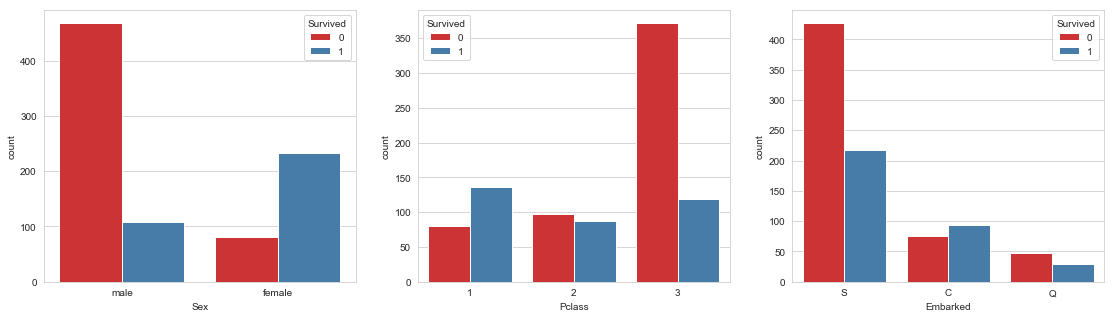

In [6]:
# 성별, 클래스, 탑승지별 생존율
figure, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(19,5)

sns.countplot(data=data_df, x='Sex', hue='Survived', palette="Set1", ax=ax1)
sns.countplot(data=data_df, x='Pclass', hue='Survived', palette="Set1", ax=ax2)
sns.countplot(data=data_df, x='Embarked', hue='Survived', palette="Set1", ax=ax3)

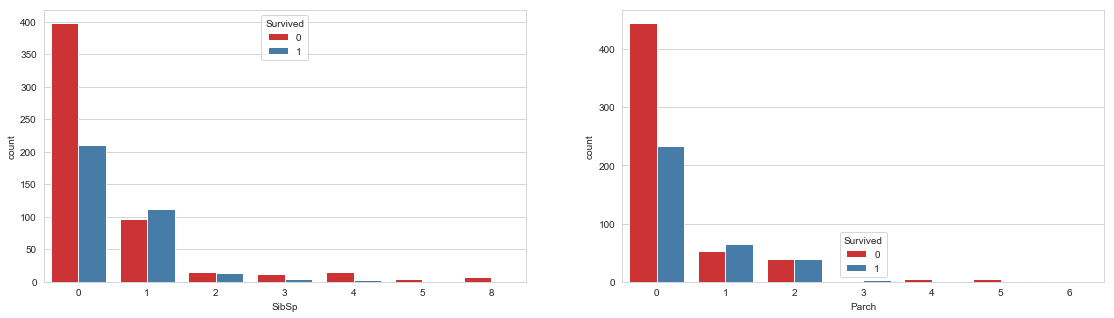

In [7]:
# Sibsp, Parch

figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(19,5)

sns.countplot(data=data_df, x='SibSp', hue='Survived', palette="Set1", ax=ax1)
sns.countplot(data=data_df, x='Parch', hue='Survived', palette="Set1", ax=ax2)

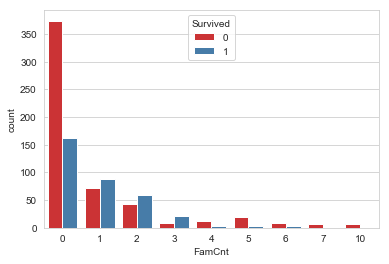

In [8]:
# SibSp와 Parch가 비슷한 양상을 보이고 있어 합치면 더 강력한 분류기준이 되지 않을까 생각함
# SibSp + Parch -> FamCnt 동행 가족 수에 따른 생존율 확인

data_df['FamCnt'] = data_df['SibSp'] + data_df['Parch'] 
sns.countplot(data=data_df, x='FamCnt', hue='Survived', palette="Set1")

In [9]:
# 동행가족이 1~3인인 부분이 생존율

# data_df['FamCate'] = data_df['FamCnt'].map(lambda x:0 if x == 0 else (1 if x<4 else 2))
# sns.countplot(data=data_df, x='FamCate', hue='Survived', palette="Set1")

## x-data / y-data 나누기

In [9]:
# y-data -> 생존율

y_data = data_df[['Survived']]
y_data.head(3)

,Survived
0,0
1,1
2,1


In [10]:
# x-data

x_data = data_df.copy()
x_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamCnt
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0


In [11]:
# 결측치 있는 열 확인 -> Age, Cabin, Embarked

x_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
FamCnt         891 non-null int64
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [12]:
# 사용하지 않을 열 삭제
x_data = x_data.drop(['Survived','Cabin','Ticket','PassengerId','SibSp','Parch'] , axis=1)

<br>

## 2. Feature engineering & Feature selection

#### 시도해볼 수 있는 전략들

- 불필요한 열이나 예측에 방해가 되는 열은 아예 지우기 (ex. PassengerId)
- 결측치 채우기 
- Text로 되어있는 Category(Factor)는 숫자로 바꿔주기 (ex. Male/Female -> 0/1)
- 실수 범위를 구간 범위로 바꿔주기 
- 필요한 경우 기존 열을 바탕으로 새로운 열을 계산해 추가하기

#### 데이터 전처리 방법과 그 근거 요약

- feature 삭제 : PassengerID / Ticket<br>

- feature 재가공 : Name -> honorifics(경칭)을 이용하여 Age 결측치 삽입 (전체 나이 중간값 삽입보다 정확도 증가)<br>

- feature 재가공 후 삭제 : Age 결측치 삽입 후, Name / Title 열 삭제<br>

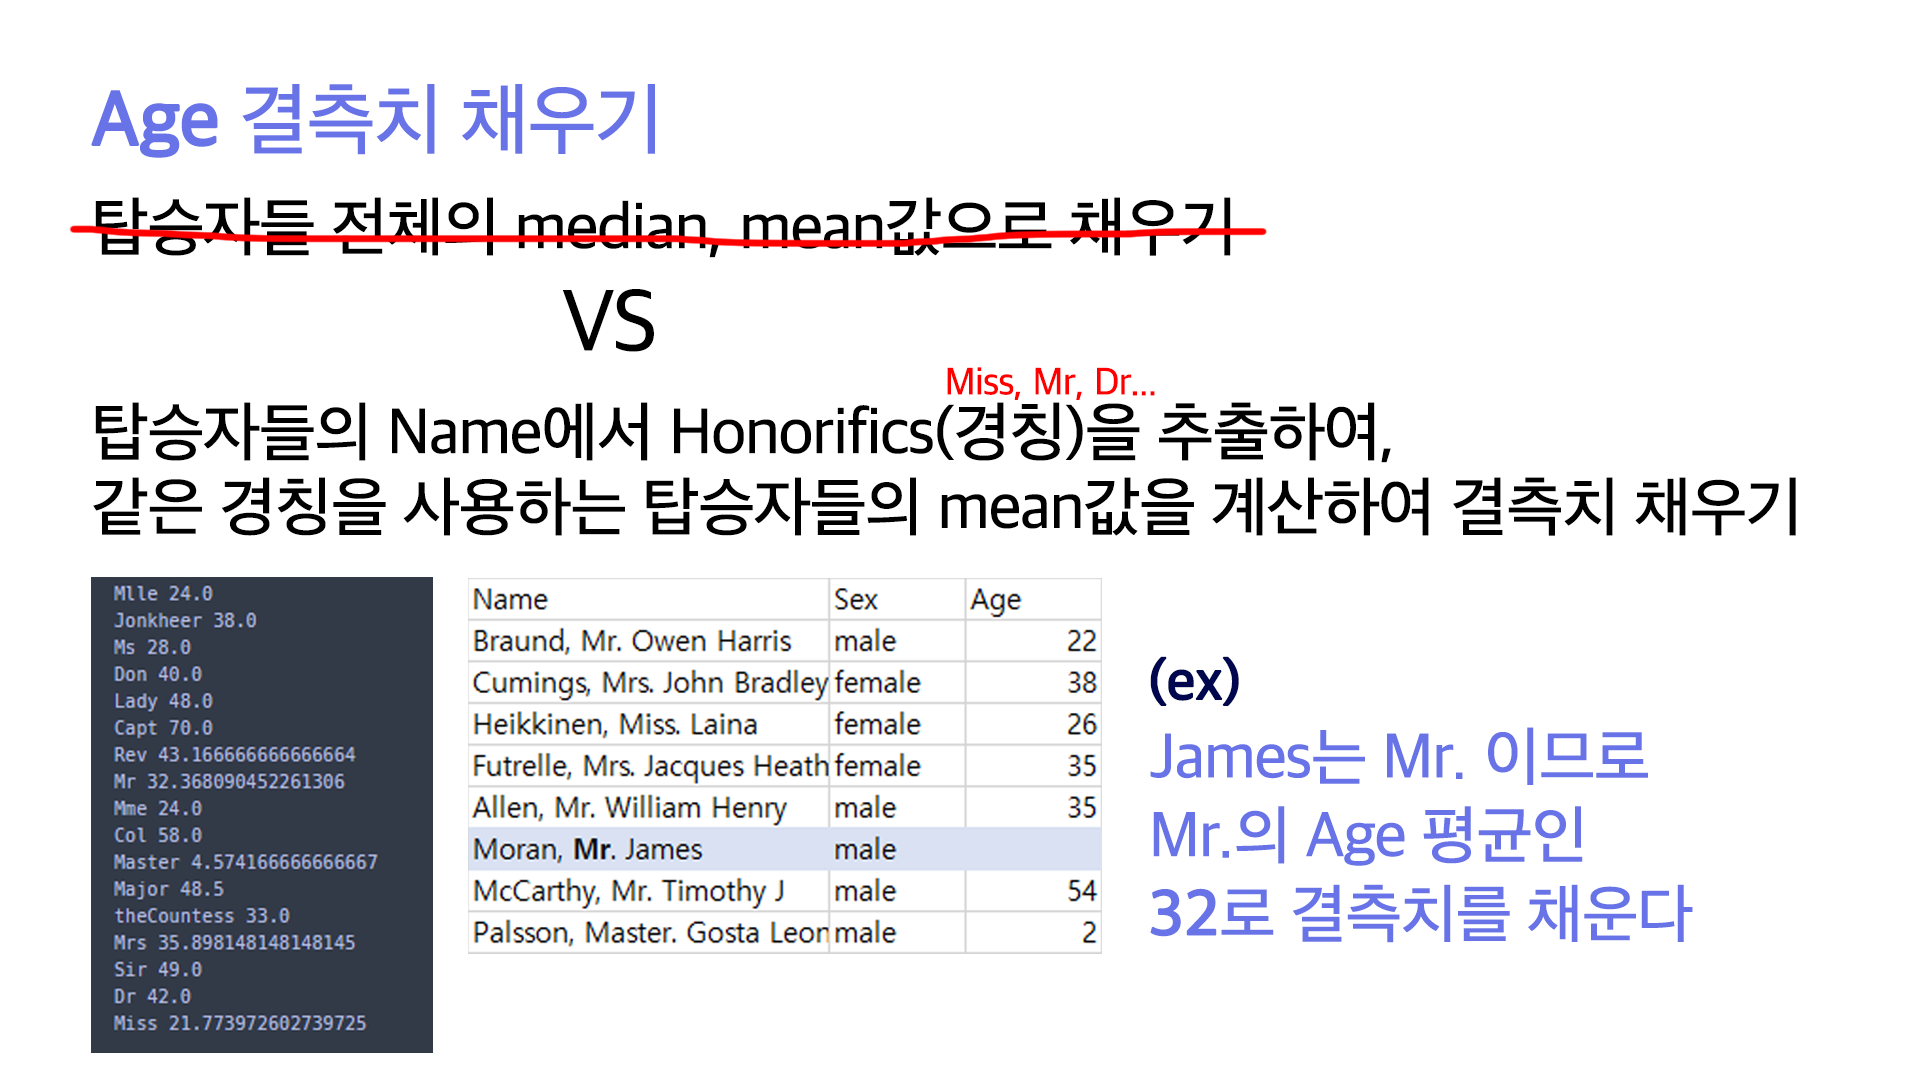

In [13]:
# 'Sex' 데이터 수치화
# male == 1 / female == 0

x_data['Sex'] = x_data['Sex'].map(lambda x : 1 if x == "male" else 0 )

In [14]:
# 'Name'열 전처리: 이름 중 중간 호칭만 분리

x_data['Title'] = x_data['Name'].map(lambda x : x.split(',')[1].split('.')[0].replace(' ',''))

In [15]:
# 'Age' 데이터 결측치 추가를 위한 전처리

# 현재 Title에 존재하는 값 확인
missing_title = set(x_data['Title'])
missing_title

{'Capt',
 'Col',
 'Don',
 'Dr',
 'Jonkheer',
 'Lady',
 'Major',
 'Master',
 'Miss',
 'Mlle',
 'Mme',
 'Mr',
 'Mrs',
 'Ms',
 'Rev',
 'Sir',
 'theCountess'}

In [16]:
# Title 중 Age가 null인 title만 뽑아내 확인해보기

set(list(x_data['Title'][x_data['Age'].isnull()]))

{'Dr', 'Master', 'Miss', 'Mr', 'Mrs'}

In [18]:
# Title의 Age 평균값을 구하여 결측치에 입력

for title in missing_title:
    age_filter = x_data[x_data['Age'].notnull()][x_data['Title']==title]
    get_mean=age_filter['Age'].mean()
#     print(title,get_mean )
    x_data['Age'][x_data['Title']==title] = x_data['Age'][x_data['Title']==title].fillna(get_mean)

x_data['Age']= x_data['Age'].astype(int)
x_data.head()


,Pclass,Name,Sex,Age,Fare,Embarked,FamCnt,Title
0,3,"Braund, Mr. Owen Harris",1,22,7.2500,S,1,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38,71.2833,C,1,Mrs
2,3,"Heikkinen, Miss. Laina",0,26,7.9250,S,0,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35,53.1000,S,1,Mrs
4,3,"Allen, Mr. William Henry",1,35,8.0500,S,0,Mr


In [19]:
# x-data 복제

x_data_copy = x_data.copy()

In [20]:
# x-data -> 'Embarked' 결측치 추가 (랜덤)

emb = list('SQC')
rand_emb = np.random.choice(emb, 1, replace=False)
x_data['Embarked'] = x_data['Embarked'].fillna(rand_emb[0])

In [21]:
# x-data copy -> 'Embarked' 수치화 & 결측치 추가 

x_data_copy['Embarked'] = x_data_copy['Embarked'].map(lambda x: 1 if x == 'S' else (2 if x == 'C' else 3))
x_data_copy['Embarked'] = x_data_copy['Embarked'].fillna(x_data_copy['Embarked'].mode())

In [22]:
# 결측치가 다 채워졌나 확인

x_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null int64
Age         891 non-null int32
Fare        891 non-null float64
Embarked    891 non-null object
FamCnt      891 non-null int64
Title       891 non-null object
dtypes: float64(1), int32(1), int64(3), object(3)
memory usage: 52.3+ KB


In [23]:
# 결측치가 다 채워졌나 확인

x_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null int64
Age         891 non-null int32
Fare        891 non-null float64
Embarked    891 non-null int64
FamCnt      891 non-null int64
Title       891 non-null object
dtypes: float64(1), int32(1), int64(4), object(2)
memory usage: 52.3+ KB


In [24]:
x_data.head()

,Pclass,Name,Sex,Age,Fare,Embarked,FamCnt,Title
0,3,"Braund, Mr. Owen Harris",1,22,7.2500,S,1,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38,71.2833,C,1,Mrs
2,3,"Heikkinen, Miss. Laina",0,26,7.9250,S,0,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35,53.1000,S,1,Mrs
4,3,"Allen, Mr. William Henry",1,35,8.0500,S,0,Mr


In [25]:
x_data_copy.head()

,Pclass,Name,Sex,Age,Fare,Embarked,FamCnt,Title
0,3,"Braund, Mr. Owen Harris",1,22,7.2500,1,1,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38,71.2833,2,1,Mrs
2,3,"Heikkinen, Miss. Laina",0,26,7.9250,1,0,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35,53.1000,1,1,Mrs
4,3,"Allen, Mr. William Henry",1,35,8.0500,1,0,Mr


In [26]:
from sklearn.preprocessing import LabelEncoder

# qcut
x_data['FareBin'] = pd.qcut(x_data['Fare'], 4)
x_data['AgeBin'] = pd.cut(x_data['Age'].astype(int), 6)

# range data to numerical values
label = LabelEncoder()
x_data['AgeBin_Code'] = label.fit_transform(x_data['AgeBin'])
x_data['FareBin_Code'] = label.fit_transform(x_data['FareBin'])


In [27]:
x_data = x_data.drop(['Title', 'Name', 'AgeBin', 'FareBin'] , axis=1)

In [28]:
# One Hot Encoding
x_data = pd.get_dummies(x_data)
x_data

,Pclass,Sex,Age,Fare,FamCnt,AgeBin_Code,FareBin_Code,Embarked_C,Embarked_Q,Embarked_S
0,3,1,22,7.2500,1,1,0,0,0,1
1,1,0,38,71.2833,1,2,3,1,0,0
2,3,0,26,7.9250,0,1,1,0,0,1
3,1,0,35,53.1000,1,2,3,0,0,1
4,3,1,35,8.0500,0,2,1,0,0,1
5,3,1,32,8.4583,0,2,1,0,1,0
6,1,1,54,51.8625,0,4,3,0,0,1
7,3,1,2,21.0750,4,0,2,0,0,1
8,3,0,27,11.1333,2,2,1,0,0,1
9,2,0,14,30.0708,1,1,2,1,0,0


In [29]:
# 사용하지 않을 열 삭제

x_data = x_data.drop(['Age', 'Fare'] , axis=1)
x_data_copy = x_data_copy.drop(['Title', 'Name'] , axis=1)

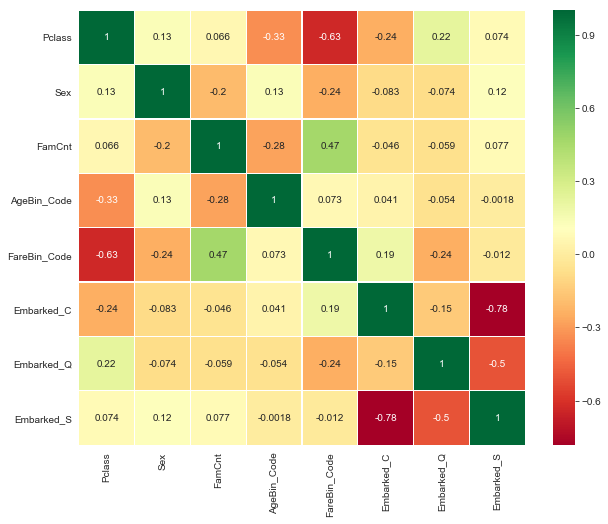

In [30]:
# correlation
import seaborn as sns

sns.heatmap(x_data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

In [31]:
x_data_copy.head()

,Pclass,Sex,Age,Fare,Embarked,FamCnt
0,3,1,22,7.2500,1,1
1,1,0,38,71.2833,2,1
2,3,0,26,7.9250,1,0
3,1,0,35,53.1000,1,1
4,3,1,35,8.0500,1,0


<br>

## 2. Train - Test split (비율을 7:3 으로 유지해주시고, seed는 0을 적용해주세요)

In [38]:
from sklearn.model_selection import train_test_split

trainX ,testX , trainY , testY = train_test_split(x_data,np.ravel(y_data, order="c"),test_size=0.3, random_state = 0)

print(trainX.shape,testX.shape,trainY.shape,testY.shape)

(623, 8) (268, 8) (623,) (268,)


In [39]:
from sklearn.preprocessing import StandardScaler

# standard scale

sc = StandardScaler()
trainX_scaled_s = sc.fit_transform(trainX)
testX_scaled_s = sc.transform(testX)

df = pd.DataFrame(trainX_scaled_s)
print(df.describe())

                  0             1             2             3             4  \
count  6.230000e+02  6.230000e+02  6.230000e+02  6.230000e+02  6.230000e+02   
mean   2.557255e-17  6.985673e-17 -1.653751e-16 -9.908250e-17  8.910297e-17   
std    1.000804e+00  1.000804e+00  1.000804e+00  1.000804e+00  1.000804e+00   
min   -1.532556e+00 -1.377561e+00 -5.486038e-01 -1.789174e+00 -1.364052e+00   
25%   -9.373053e-01 -1.377561e+00 -5.486038e-01 -7.684272e-01 -4.732717e-01   
50%    8.484476e-01  7.259206e-01 -5.486038e-01  2.523194e-01  4.175086e-01   
75%    8.484476e-01  7.259206e-01  4.476454e-02  2.523194e-01  1.308289e+00   
max    8.484476e-01  7.259206e-01  5.385079e+00  3.314559e+00  1.308289e+00   

                  5             6             7  
count  6.230000e+02  6.230000e+02  6.230000e+02  
mean  -1.753546e-16 -1.042505e-16  3.268297e-16  
std    1.000804e+00  1.000804e+00  1.000804e+00  
min   -4.579397e-01 -3.142697e-01 -1.672956e+00  
25%   -4.579397e-01 -3.142697e-01 -1.6

C:\Users\kimsh\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\kimsh\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\kimsh\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype uint8, int32, int64 were all converted to float64 by StandardScaler.
  import sys


In [40]:
# min-max scale

min_on_training = trainX.min(axis=0) # 열마다의 최소값 계산
range_on_training = (trainX - min_on_training).max(axis=0) # 분모에 해당 
trainX_scaled_mm = (trainX - min_on_training) / range_on_training # Min-max scaling (0~1)
testX_scaled_mm = (testX- min_on_training) / range_on_training

<br>

## 3. Create model instance variable (동시에 여러 모델을 다른 이름으로 만들 수 있습니다.)

In [41]:
from sklearn import metrics

# 모델 함수 만들기
def train_and_test(model): 
    model.fit(trainX, trainY) 
    prediction = model.predict(testX)
    accuracy = round(metrics.accuracy_score(testY, prediction) * 100, 2) 
    print("Accuracy : ", accuracy, "%") 
    
    from sklearn.metrics import f1_score
    print(f"F1 Score: {round(f1_score(testY, prediction, average='micro') * 100, 2)}%")
    
    return prediction
          

In [57]:
# KNN

from sklearn.neighbors import KNeighborsClassifier
knn_prd = train_and_test(KNeighborsClassifier(32))

Accuracy :  80.6 %
F1 Score: 80.6%


In [45]:
# LinearSVC

from sklearn.svm import LinearSVC
clf_pred = train_and_test(LinearSVC())

Accuracy :  79.85 %
F1 Score: 79.85%


C:\Users\kimsh\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [44]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression
log_pred = train_and_test(LogisticRegression())

Accuracy :  80.6 %
F1 Score: 80.6%


In [46]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest_predict = train_and_test(forest)

Accuracy :  83.96 %
F1 Score: 83.96%


In [47]:
# SVC

from sklearn.svm import SVC
svc_pred = train_and_test(SVC(kernel='rbf', C=1, gamma=0.1))


Accuracy :  81.72 %
F1 Score: 81.72%


In [48]:
# GNB

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
gnb_pred = train_and_test(GaussianNB())


Accuracy :  77.99 %
F1 Score: 77.99%


In [49]:
# DecisionTreeClassifier

from sklearn.tree import DecisionTreeClassifier
dec_pred = train_and_test(DecisionTreeClassifier(min_samples_split=50))


Accuracy :  81.34 %
F1 Score: 81.34%


In [50]:
# GBC

from sklearn.ensemble import GradientBoostingClassifier
gbc_pred = train_and_test(GradientBoostingClassifier(min_samples_split=50))

Accuracy :  83.21 %
F1 Score: 83.21%


In [ ]:
# 설치 문제로 생략

!conda install -c anaconda py-xgboost
# XG Boost

from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb_predict = train_and_test(xgb)

## KNN 성능 향상을 위한 작업
-> KNN 성능이 잘 나오지 않아 추가적으로 성능 향상을 위해 여러 작업을 시도함

In [51]:
# 나이대를 세 부분으로 나눠서 생존율 구해보기
# try1: AgeCate01 -> 0~19: 0 / 20~49: 1 / 50~: 2 -> 
# try2: AgeCate -> 10살 간격으로 나눠보기

# x_data['AgeCate01'] = x_data['Age'].map(lambda x:0 if x < 20 else (2 if x >= 50 else 1))
x_data_copy['AgeCate'] = x_data_copy['Age'].map(lambda x:0 if (x//10<0) else x//10)


In [52]:
x_train, x_test, y_train, y_test = train_test_split(x_data_copy,np.ravel(y_data, order="c"),test_size=0.3, random_state = 0)

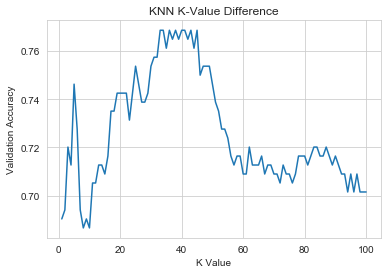

In [55]:
# 성능 향상을 위해 k 값 변경해보기

k_list = range(1,101)
accuracies = []

for k in k_list:
    knn_model = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(x_train, np.ravel (y_train, order = "c"))
    accuracies.append(knn_model.score(x_test, y_test))

# accuracies
plt.plot(k_list, accuracies)
plt.xlabel("K Value")
plt.ylabel("Validation Accuracy")
plt.title("KNN K-Value Difference")
plt.show()

In [56]:
print("max accuracy: ", max(accuracies), " / index: ", accuracies.index(max(accuracies)))
print("min accuracy: ", min(accuracies), " / index: ", accuracies.index(min(accuracies)))

max accuracy:  0.7686567164179104  / index:  32
min accuracy:  0.6865671641791045  / index:  7


<br>

## +) 다양한 시도해보기

***k-fold 적용해보기***

In [58]:
from sklearn.model_selection import StratifiedKFold

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

In [60]:
from sklearn.model_selection import cross_val_score

logit_kfold = cross_val_score(LogisticRegression(),trainX,trainY , cv=skf)
linearSVC_kfold = cross_val_score(LinearSVC(),trainX,trainY , cv=skf)
forest_kfold = cross_val_score(forest,trainX,trainY , cv=skf)
knn_kfold = cross_val_score(KNeighborsClassifier(10),trainX,trainY , cv=skf)
svc_kfold = cross_val_score(SVC(),trainX,trainY , cv=skf)


# lgb_kfold = cross_val_score(lgb,trainX,trainY , cv=skf)
# xgb_kfold = cross_val_score(xgb,trainX,trainY , cv=skf)


print()

print(f"LogisticRegression : {logit_kfold[-1]}")
print(f"LinearSVC : {linearSVC_kfold[-1]}")
print(f"Random forest : {forest_kfold[-1]}")
print(f"KNN : {knn_kfold[-1]}")
print(f"SVC : {svc_kfold[-1]}")

# print(f"XGBoost : {xgb_kfold[-1]}")
# print(f"LightGBM : {lgb_kfold[-1]}")

C:\Users\kimsh\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\kimsh\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\kimsh\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\kimsh\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\kimsh\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 


LogisticRegression : 0.7903225806451613
LinearSVC : 0.7903225806451613
Random forest : 0.8306451612903226
KNN : 0.8225806451612904
SVC : 0.8306451612903226


In [62]:
from sklearn.metrics import confusion_matrix, classification_report

forest_ = forest.fit(trainX,trainY)

# Random Forest
print(confusion_matrix(forest_.predict(testX), testY))
print(classification_report(forest_.predict(testX), testY))

[[153  28]
 [ 15  72]]
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       181
           1       0.72      0.83      0.77        87

   micro avg       0.84      0.84      0.84       268
   macro avg       0.82      0.84      0.82       268
weighted avg       0.85      0.84      0.84       268



In [63]:
from sklearn.metrics import roc_curve, auc

# Rnadom Forest 커브 그리기 
model = forest_
pred_test = model.predict_proba(testX)

# X축, Y축 생성
fpr, tpr, _ = roc_curve(y_true=testY, y_score=pred_test[:,1]) # real y & predicted y (based on "Sepal width")
roc_auc = auc(fpr, tpr) # AUC 면적의 값 (수치)

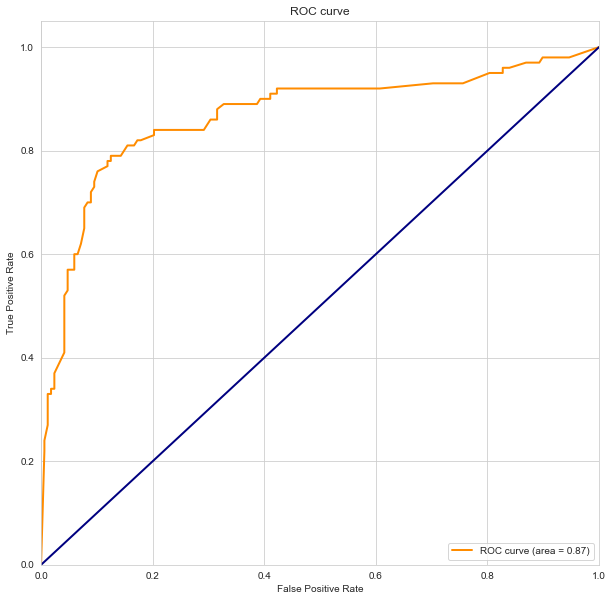

In [64]:
# Random Forest 커브 그래프 그리기
plt.figure(figsize=(10, 10))

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2)
# linestyle='—'
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("ROC curve")

plt.show()

***Model Stacking***

위에 다양한 모델들 중 accuracy가 높았던 것들로 stacking 해보기
최종: SVM / 트레이닝: Gradient Boosting, Random Forest, Logistic Regression

In [ ]:
# Gradient Boosting
model_gradient = ensemble.GradientBoostingClassifier(random_state=0)
model_gradient.fit(x_train, np.ravel(y_train, order="c"))

In [ ]:
# Random Forest
model_forest = ensemble.RandomForestClassifier(n_estimators=13)
model_forest.fit(x_train, np.ravel(y_train, order="c"))

In [ ]:
# Logistic Regression
model_logistic = linear_model.LogisticRegression()
model_logistic.fit(x_train, np.ravel(y_train, order="c"))

In [ ]:
pred_gradient = model_gradient.predict(x_test)
pred_forest = model_forest.predict(x_test)
pred_logistic = model_logistic.predict(x_test)

In [ ]:
stacked_data = np.array([pred_gradient, pred_forest, pred_logistic])
stacked_data = np.transpose(stacked_data)
stacked_data.shape

In [ ]:
model_svm = svm.SVC()
model_svm.fit(stacked_data, np.ravel(y_test, order="c"))
pred_svm = model_svm.predict(stacked_data)
print(accuracy_score(y_test, pred_svm))